In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import logging
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.data import DataStore
from astropy.table import Table
from pathlib import Path
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
log = logging.getLogger(__name__)

In [177]:
from gammapy.modeling.models import PowerLawSpectralModel
from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, Models
from gammapy.estimators import LightCurveEstimator
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore


In [179]:
conf_3d = AnalysisConfig()

In [178]:
conf_1d = AnalysisConfig()

In [180]:
#obs_ids=[5580, 5581, 5582, 5583, 5584] 
#obs_ids=[5630, 5631, 5632, 5633, 5634, 5635, 5637,5636,  5638, 5639]
#obs_ids=[5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704 ]
obs_ids=[5580, 5581, 5582, 5583, 5584,
        5630, 5631, 5632, 5633, 5634, 5635, 5637,5636,  5638, 5639,
        5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704]
        #5890, 5891, 5892, 5893,
        #5912, 5913, 5914, 5915, 5916, 5917,
        #5942, 5943, 5944, 5945,
        #5970, 5971, 5972, 5973]

In [186]:
t_start = []
t_stop = []
tot_time = []
obj_name = []
ogip_path=Path(basedir+"OGIP/")
for obs in obs_ids:
    file = ogip_path / f"pha_obs_{obs}.fits.gz"
    t = Table.read(file, hdu="GTI")
    r = Table.read(file, hdu="REGION").meta
    
    t_start.append(t["START"][0])
    t_stop.append(t["STOP"][0])
    tot_time.append(t["STOP"][0] - t["START"][0])
    
    obj_name.append(r["OBJECT"])
print(obs_ids)

t_start = np.sort(np.array(t_start))
t_stop = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)
print(tot_time.sum()/3600)

obj_name = np.unique(np.array(obj_name))[0]

[5580, 5581, 5582, 5583, 5584, 5630, 5631, 5632, 5633, 5634, 5635, 5637, 5636, 5638, 5639, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704]
6.685089589622286


In [187]:
basedir="/fefs/aswg/workspace/maria.bernardos/LSTanalysis/full_analysis/data/real/DL3/rsoph_first3nights/v0.9.0rsoph/gcut_0.60_tcut_0.20/tailcut84/"
datastore = DataStore.from_dir(basedir)
observations = datastore.get_observations(obs_ids, required_irf=["aeff", "bkg", "edisp"])

No HDU found matching: OBS_ID = 5580, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5580, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5581, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5581, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5582, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5582, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5583, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5583, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5584, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5584, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5630, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5630, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5631, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5631, HDU_TYPE = rad_

In [188]:
conf_3d.observations.obs_ids = obs_ids

In [184]:
# We want a 3D analysis
conf_3d.datasets.type = "3d"

# We want to extract the data by observation and therefore to not stack them
conf_3d.datasets.stack = False

# Here is the WCS geometry of the Maps
conf_3d.datasets.geom.wcs.skydir = dict(
    frame="icrs", lon=267.55483032 * u.deg, lat=-6.7077778 * u.deg
)
conf_3d.datasets.geom.wcs.binsize = 0.02 * u.deg
conf_3d.datasets.geom.wcs.width = dict(width=1 * u.deg, height=1 * u.deg)

# We define a value for the IRF Maps binsize
conf_3d.datasets.geom.wcs.binsize_irf = 0.2 * u.deg

# Define energy binning for the Maps
conf_3d.datasets.geom.axes.energy = dict(
    min=0.1 * u.TeV, max=1 * u.TeV, nbins=5
)
conf_3d.datasets.geom.axes.energy_true = dict(
    min=0.01 * u.TeV, max=100 * u.TeV, nbins=20
)

In [189]:
analysis_3d = Analysis(conf_3d)
analysis_3d.get_observations()
analysis_3d.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


FileNotFoundError: Datastore not found: /fefs/aswg/workspace/maria.bernardos/LSTanalysis/data_MC_comp/gammapy-datasets/hess-dl3-dr1

In [191]:
analysis_3d.datasets=datasets
analysis_3d=observations

In [127]:
# We want a 1D analysis
conf_1d.datasets.type = "1d"

# We want to extract the data by observation and therefore to not stack them
conf_1d.datasets.stack = False

# Here we define the ON region and make sure that PSF leakage is corrected
conf_1d.datasets.on_region = dict(
    frame="icrs",
    lon=267.55483032 * u.deg,
    lat=-6.7077778 * u.deg,
    radius=0.1 * u.deg,
)
conf_1d.datasets.containment_correction = True

# Finally we define the energy binning for the spectra
conf_1d.datasets.geom.axes.energy = dict(
    min=0.01 * u.TeV, max=1 * u.TeV, nbins=5
)
conf_1d.datasets.geom.axes.energy_true = dict(
    min=0.01 * u.TeV, max=100 * u.TeV, nbins=20
)

In [128]:
#Define the ON region
target_position = SkyCoord(ra=267.55483032, dec=-6.7077778, unit="deg", frame="icrs")
on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [129]:
#Configuration of the maker classes

energy_axis = MapAxis.from_energy_bounds(
    0.01, 1, 10, unit="TeV",
    name="energy")
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 1, 200, unit="TeV", name="energy_true"
)
geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

bkg_maker = ReflectedRegionsBackgroundMaker(max_region_number=3, min_distance_input="2 rad")
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

datasets = Datasets()

In [130]:
#We can define the range we want to use for the fitting
e_reco_max=2
e_fit_min=0.01 * u.TeV
e_fit_max=1 * u.TeV

In [131]:
#Build the on/off datasets
for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    
    #Mask for fitting only the specific range, comment to fit the full range
    mask_fit = Map.from_geom(geom=dataset_on_off.counts.geom, data = dataset_on_off.counts.geom.get_coord()["energy"] < 10**e_reco_max * u.TeV)
    dataset_on_off.counts.geom.energy_mask(energy_min=e_fit_min, energy_max=e_fit_max)
    dataset_on_off.mask_fit = mask_fit
    #=========================================
    print(obs_id)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5580


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5581


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5582


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5583


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5584


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5630


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5631


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5632


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5633


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5634


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5635


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5637


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5636


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5638


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5639


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5696


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5697


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5698


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5699


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5700


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5701


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5702


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5703


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


5704


In [132]:
spectral_model = PowerLawSpectralModel(
    index=3, amplitude=4e-13 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name=obj_name)
for dataset in datasets:
    dataset.models = model

In [133]:
#Fit the spectral model to the data

fit_joint = Fit()
result_joint = fit_joint.run(datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 81
	total stat : 105.65

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 81
	total stat : 105.65




In [134]:
%%time
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_fit_min, e_fit_max], reoptimize=True, source=obj_name
)

CPU times: user 982 µs, sys: 130 µs, total: 1.11 ms
Wall time: 1.27 ms


In [135]:
# Need the time start and end
t_start = Time(t_start, format='unix')
t_stop = Time(t_stop, format='unix')

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

lc_maker_night_wise = LightCurveEstimator(
    energy_edges=[e_fit_min, e_fit_max], 
    time_intervals=t_range,
    reoptimize=False, source=obj_name
)

In [136]:
time_intervals = [
    Time([59435.0, 59436.0], format="mjd", scale="utc"),
    Time([59436.0, 59437.0], format="mjd", scale="utc"),
    Time([59438.0, 59439.0], format="mjd", scale="utc"),
    #Time([59455.0, 59456.0], format="mjd", scale="utc"),
    #Time([59456.0, 59457.0], format="mjd", scale="utc"),
    #Time([59458.0, 59459.0], format="mjd", scale="utc"),
    #Time([59459.0, 59460.0], format="mjd", scale="utc"),
]

In [169]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.1, 1] * u.TeV, source=obj_name, reoptimize=False, time_intervals=t_range
)
lc_1d = lc_maker_1d.run(datasets)

In [170]:
lc_1d.to_hdulist().info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  NORM          1 BinTableHDU     21   3R x 2C   ['I', 'D']   
  2  NORM_BANDS    1 BinTableHDU     36   3R x 7C   ['K', 'D', 'D', 'D', 'D', 'D', 'D']   
  3  NORM_ERR      1 BinTableHDU     21   3R x 2C   ['I', 'D']   
  4  NORM_ERR_BANDS    1 BinTableHDU     36   3R x 7C   ['K', 'D', 'D', 'D', 'D', 'D', 'D']   
  5  TS            1 BinTableHDU     21   3R x 2C   ['I', 'D']   
  6  TS_BANDS      1 BinTableHDU     36   3R x 7C   ['K', 'D', 'D', 'D', 'D', 'D', 'D']   
  7  SQRT_TS       1 BinTableHDU     21   3R x 2C   ['I', 'D']   
  8  SQRT_TS_BANDS    1 BinTableHDU     36   3R x 7C   ['K', 'D', 'D', 'D', 'D', 'D', 'D']   
  9  NPRED         1 BinTableHDU     22   72R x 2C   ['I', 'D']   
 10  NPRED_BANDS    1 BinTableHDU     39   72R x 8C   ['K', '4A', 'D', 'D', 'D', 'D', 'D', 'D']   
 11  NPRED_EXCESS    1 BinTableHDU   

In [171]:
lc_1d.flux.data

array([[[[5.01626601e-11]]],


       [[[4.65032403e-11]]],


       [[[4.72501622e-11]]]])

In [172]:
lc_1d.eflux.data

array([[[[7.51956992e-12]]],


       [[[6.97100925e-12]]],


       [[[7.08297562e-12]]]])

In [173]:
lc_1d.flux.data

array([[[[5.01626601e-11]]],


       [[[4.65032403e-11]]],


       [[[4.72501622e-11]]]])

In [174]:
lc_1d.to_hdulist()[5].data

FITS_rec([(0, 4.19162883), (1, 7.35135012), (2, 6.30059255)],
         dtype=(numpy.record, [('CHANNEL', '<i2'), ('DATA', '<f8')]))

<AxesSubplot:xlabel='Time [iso]', ylabel='dnde (1 / (cm2 s TeV))'>

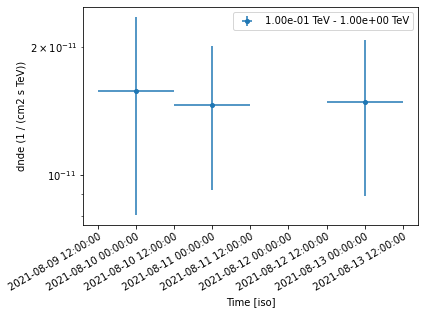

In [175]:
lc_1d.plot(marker="o")
#ax.grid()
#ax.set_ylim([1e-14,2e-12])


In [154]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.01, 1] * u.TeV, source=obj_name, reoptimize=False
)
lc_1d = lc_maker_1d.run(datasets)

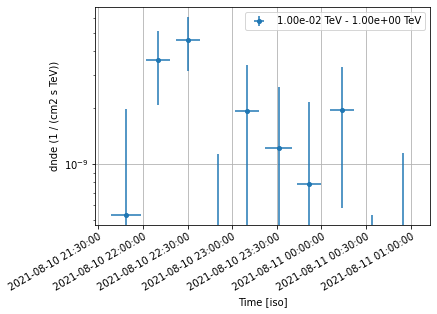

In [113]:
ax = lc_1d.plot(marker="o")
ax.grid()